In [11]:
!pip install q keras==2.1.5

  ERROR: Could not find a version that satisfies the requirement keras-gpu==2.1.5 (from versions: none)
ERROR: No matching distribution found for keras-gpu==2.1.5


In [2]:
# %tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
import Ipynb_importer
import keras
# from tensorflow import keras
from keras import backend as K
from keras.optimizers import Optimizer
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
import numpy as np
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from optimizers import MaSS
from cifar10 import load
from resnet import resnet_v1, resnet_v2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 

In [3]:
tf.__version__

'1.14.0'

In [4]:
keras.__version__

'2.1.5'

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 
batch_size = 64
epochs = 80
data_augmentation = True
num_classes = 10
learning_rate=0.3
# Load Cifar-10 data
(x_train, y_train), (x_test, y_test) = load()
input_shape = x_train.shape[1:]

# Model parameters
n = 5
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
##############################################################################
#CNN
class Lenet:
      def neural(channel,height,width,classes):
              input_shape = (channel,height,width)
              if K.image_data_format() == "channels_last":input_shape = (height,width,channel)
              model = Sequential()
              model.add(Conv2D(64,(5,5),padding="same",activation="relu",input_shape=input_shape,name="conv1"))
              model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool1"))

              model.add(Conv2D(64,(5,5),padding="same",activation="relu",name="conv2",))
              model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool2"))

              model.add(Conv2D(128,(5,5),padding="same",activation="relu",name="conv3",))
              model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool3"))

              model.add(Flatten())
              model.add(Dense(128,activation="relu",name="fc1"))
              model.add(Dense(classes,activation="softmax",name="fc2"))
              return model
################################################################
#仅测试resNet 50 epochs
################################################################
# Build model
channel = 3
height = 32
width = 32
class_num = 10
norm_size = 32

model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
# model = resnet_v1(input_shape=input_shape, depth=depth)
mass = MaSS(learning_rate = learning_rate, alpha = 0.05, kappa_t = 6)
model.compile(loss='categorical_crossentropy',
              optimizer=mass,
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result1 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res1 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result1 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

Load CIFAR-10 dataset.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
____________________

782/782 [==============================] - 11s 14ms/step - loss: 1.3826 - acc: 0.5538 - val_loss: 1.4137 - val_acc: 0.5579

Epoch 00029: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.029.h5
Epoch 30/80
782/782 [==============================] - 11s 14ms/step - loss: 1.3956 - acc: 0.5545 - val_loss: 1.5459 - val_acc: 0.5439

Epoch 00030: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.030.h5
Epoch 31/80
782/782 [==============================] - 11s 14ms/step - loss: 1.4200 - acc: 0.5458 - val_loss: 1.4287 - val_acc: 0.5816

Epoch 00031: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.031.h5
Epoch 32/80
782/782 [==============================] - 11s 14ms/step - loss: 1.4305 - acc: 0.5427 - val_loss: 1.6053 - val_acc: 0.5248

Epoch 00032: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.032.h5
Epoch 33/80
782/782 [==============================] - 11s 14ms/step - loss: 1.4163 - ac


Epoch 00064: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.064.h5
Epoch 65/80
782/782 [==============================] - 12s 15ms/step - loss: 1.8672 - acc: 0.3768 - val_loss: 1.8388 - val_acc: 0.4017

Epoch 00065: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.065.h5
Epoch 66/80
782/782 [==============================] - 12s 15ms/step - loss: 1.7636 - acc: 0.4144 - val_loss: 1.7432 - val_acc: 0.4162

Epoch 00066: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.066.h5
Epoch 67/80
782/782 [==============================] - 12s 15ms/step - loss: 1.7432 - acc: 0.4149 - val_loss: 1.7638 - val_acc: 0.4150

Epoch 00067: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.067.h5
Epoch 68/80
782/782 [==============================] - 12s 15ms/step - loss: 1.7114 - acc: 0.4248 - val_loss: 1.6540 - val_acc: 0.4614

Epoch 00068: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v

In [10]:
!pip install matplotlib

<function matplotlib.pyplot.show(*args, **kw)>

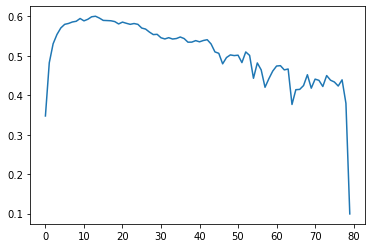

In [14]:
import matplotlib.pyplot as plt

plt.plot(result1.history['acc'])
plt.show

In [16]:
# Build model
channel = 3
height = 32
width = 32
class_num = 10
norm_size = 32

model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
# model = resnet_v1(input_shape=input_shape, depth=depth)
mass = MaSS(learning_rate = 0.01, alpha = 0.05, kappa_t = 3)
model.compile(loss='categorical_crossentropy',
              optimizer=mass,
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result1_1 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res1_1 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result1_1 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
__________

782/782 [==============================] - 12s 16ms/step - loss: 0.3799 - acc: 0.8668 - val_loss: 0.5827 - val_acc: 0.8144

Epoch 00030: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.030.h5
Epoch 31/80
782/782 [==============================] - 12s 16ms/step - loss: 0.3727 - acc: 0.8696 - val_loss: 0.5592 - val_acc: 0.8242

Epoch 00031: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.031.h5
Epoch 32/80
782/782 [==============================] - 12s 16ms/step - loss: 0.3624 - acc: 0.8728 - val_loss: 0.5616 - val_acc: 0.8245

Epoch 00032: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.032.h5
Epoch 33/80
782/782 [==============================] - 12s 16ms/step - loss: 0.3550 - acc: 0.8749 - val_loss: 0.5675 - val_acc: 0.8227

Epoch 00033: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.033.h5
Epoch 34/80
782/782 [==============================] - 13s 16ms/step - loss: 0.3409 - ac

782/782 [==============================] - 12s 15ms/step - loss: 0.1895 - acc: 0.9330 - val_loss: 0.6352 - val_acc: 0.8369

Epoch 00065: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.065.h5
Epoch 66/80
782/782 [==============================] - 12s 15ms/step - loss: 0.1876 - acc: 0.9325 - val_loss: 0.6267 - val_acc: 0.8340

Epoch 00066: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.066.h5
Epoch 67/80
782/782 [==============================] - 12s 15ms/step - loss: 0.1818 - acc: 0.9351 - val_loss: 0.6392 - val_acc: 0.8341

Epoch 00067: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.067.h5
Epoch 68/80
782/782 [==============================] - 13s 16ms/step - loss: 0.1787 - acc: 0.9366 - val_loss: 0.6534 - val_acc: 0.8365

Epoch 00068: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.068.h5
Epoch 69/80
782/782 [==============================] - 13s 17ms/step - loss: 0.1766 - ac

<function matplotlib.pyplot.show(*args, **kw)>

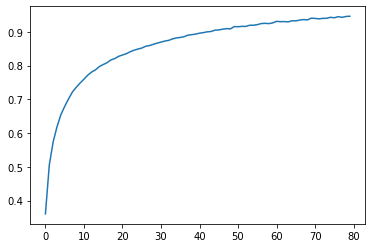

In [17]:
import matplotlib.pyplot as plt

plt.plot(result1_1.history['acc'])
plt.show

In [18]:
# Build model
channel = 3
height = 32
width = 32
class_num = 10
norm_size = 32

model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
# model = resnet_v1(input_shape=input_shape, depth=depth)
mass = MaSS(learning_rate = 0.05, alpha = 0.05, kappa_t = 4)
model.compile(loss='categorical_crossentropy',
              optimizer=mass,
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result1_2 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res1_2 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result1_2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
__________

782/782 [==============================] - 13s 16ms/step - loss: 0.3320 - acc: 0.8847 - val_loss: 0.6749 - val_acc: 0.8154

Epoch 00030: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.030.h5
Epoch 31/80
782/782 [==============================] - 12s 15ms/step - loss: 0.3288 - acc: 0.8864 - val_loss: 0.6326 - val_acc: 0.8180

Epoch 00031: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.031.h5
Epoch 32/80
782/782 [==============================] - 11s 15ms/step - loss: 0.3169 - acc: 0.8893 - val_loss: 0.6688 - val_acc: 0.8203

Epoch 00032: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.032.h5
Epoch 33/80
782/782 [==============================] - 14s 17ms/step - loss: 0.3164 - acc: 0.8896 - val_loss: 0.6388 - val_acc: 0.8172

Epoch 00033: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.033.h5
Epoch 34/80
782/782 [==============================] - 15s 19ms/step - loss: 0.3027 - ac


Epoch 00065: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.065.h5
Epoch 66/80
782/782 [==============================] - 12s 16ms/step - loss: 0.2425 - acc: 0.9180 - val_loss: 0.7654 - val_acc: 0.8258

Epoch 00066: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.066.h5
Epoch 67/80
782/782 [==============================] - 12s 16ms/step - loss: 0.2429 - acc: 0.9179 - val_loss: 0.7868 - val_acc: 0.8254

Epoch 00067: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.067.h5
Epoch 68/80
782/782 [==============================] - 12s 16ms/step - loss: 0.2386 - acc: 0.9195 - val_loss: 0.8154 - val_acc: 0.8177

Epoch 00068: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.068.h5
Epoch 69/80
782/782 [==============================] - 13s 16ms/step - loss: 0.2401 - acc: 0.9179 - val_loss: 0.7775 - val_acc: 0.8230

Epoch 00069: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v

<function matplotlib.pyplot.show(*args, **kw)>

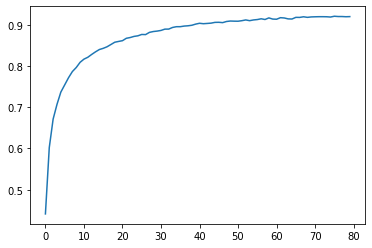

In [19]:
import matplotlib.pyplot as plt

plt.plot(result1_2.history['acc'])
plt.show

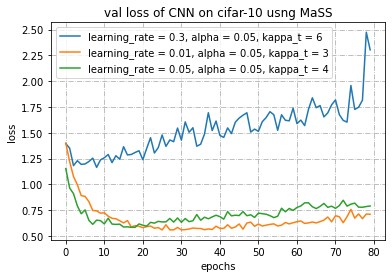

In [20]:
plt.plot(result1.history['val_loss'],label='learning_rate = 0.3, alpha = 0.05, kappa_t = 6')
plt.plot(result1_1.history['val_loss'],label='learning_rate = 0.01, alpha = 0.05, kappa_t = 3')
plt.plot(result1_2.history['val_loss'],label='learning_rate = 0.05, alpha = 0.05, kappa_t = 4')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("val loss of CNN on cifar-10 usng MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

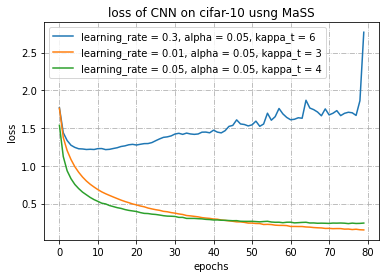

In [21]:
plt.plot(result1.history['loss'],label='learning_rate = 0.3, alpha = 0.05, kappa_t = 6')
plt.plot(result1_1.history['loss'],label='learning_rate = 0.01, alpha = 0.05, kappa_t = 3')
plt.plot(result1_2.history['loss'],label='learning_rate = 0.05, alpha = 0.05, kappa_t = 4')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss of CNN on cifar-10 usng MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

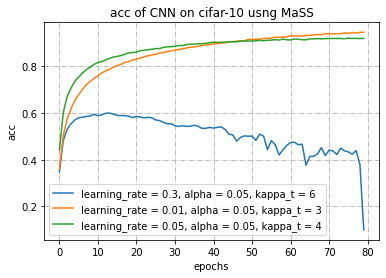

In [22]:
plt.plot(result1.history['acc'],label='learning_rate = 0.3, alpha = 0.05, kappa_t = 6')
plt.plot(result1_1.history['acc'],label='learning_rate = 0.01, alpha = 0.05, kappa_t = 3')
plt.plot(result1_2.history['acc'],label='learning_rate = 0.05, alpha = 0.05, kappa_t = 4')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title("acc of CNN on cifar-10 usng MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

In [23]:
# model = resnet_v1(input_shape=input_shape, depth=depth)
model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result2 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res2 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
__________

782/782 [==============================] - 13s 16ms/step - loss: 0.5933 - acc: 0.8036 - val_loss: 0.8454 - val_acc: 0.7728

Epoch 00030: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.030.h5
Epoch 31/80
782/782 [==============================] - 13s 17ms/step - loss: 0.5888 - acc: 0.8041 - val_loss: 0.8445 - val_acc: 0.7550

Epoch 00031: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.031.h5
Epoch 32/80
782/782 [==============================] - 13s 17ms/step - loss: 0.5870 - acc: 0.8064 - val_loss: 0.8425 - val_acc: 0.7635

Epoch 00032: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.032.h5
Epoch 33/80
782/782 [==============================] - 13s 16ms/step - loss: 0.5976 - acc: 0.8039 - val_loss: 0.7883 - val_acc: 0.7657

Epoch 00033: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.033.h5
Epoch 34/80
782/782 [==============================] - 13s 17ms/step - loss: 0.5985 - ac


Epoch 00065: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.065.h5
Epoch 66/80
782/782 [==============================] - 12s 15ms/step - loss: 0.6204 - acc: 0.8057 - val_loss: 0.8763 - val_acc: 0.7696

Epoch 00066: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.066.h5
Epoch 67/80
782/782 [==============================] - 13s 16ms/step - loss: 0.6334 - acc: 0.8018 - val_loss: 0.9005 - val_acc: 0.7628

Epoch 00067: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.067.h5
Epoch 68/80
782/782 [==============================] - 13s 16ms/step - loss: 0.6329 - acc: 0.8015 - val_loss: 1.0061 - val_acc: 0.7512

Epoch 00068: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.068.h5
Epoch 69/80
782/782 [==============================] - 13s 16ms/step - loss: 0.6373 - acc: 0.8040 - val_loss: 0.9681 - val_acc: 0.7567

Epoch 00069: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v

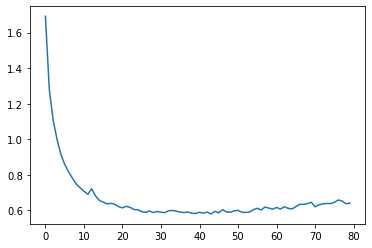

In [24]:
import matplotlib.pyplot as plt
# 上升可能是因为学习率太大
plt.plot(result2.history['loss'])

In [25]:
# model = resnet_v1(input_shape=input_shape, depth=depth)
model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate,momentum=0.9,nesterov=True),
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result3 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res3 = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result3 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
__________

782/782 [==============================] - 13s 16ms/step - loss: 2.3115 - acc: 0.1013 - val_loss: 2.3109 - val_acc: 0.1000

Epoch 00030: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.030.h5
Epoch 31/80
782/782 [==============================] - 13s 16ms/step - loss: 2.3110 - acc: 0.1004 - val_loss: 2.3114 - val_acc: 0.1000

Epoch 00031: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.031.h5
Epoch 32/80
782/782 [==============================] - 13s 16ms/step - loss: 2.3113 - acc: 0.0996 - val_loss: 2.3097 - val_acc: 0.1000

Epoch 00032: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.032.h5
Epoch 33/80
782/782 [==============================] - 13s 16ms/step - loss: 2.3116 - acc: 0.0982 - val_loss: 2.3082 - val_acc: 0.1000

Epoch 00033: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.033.h5
Epoch 34/80
782/782 [==============================] - 13s 16ms/step - loss: 2.3117 - ac

782/782 [==============================] - 13s 16ms/step - loss: 2.3116 - acc: 0.1009 - val_loss: 2.3112 - val_acc: 0.1000

Epoch 00065: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.065.h5
Epoch 66/80
782/782 [==============================] - 12s 16ms/step - loss: 2.3115 - acc: 0.1003 - val_loss: 2.3093 - val_acc: 0.1000

Epoch 00066: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.066.h5
Epoch 67/80
782/782 [==============================] - 12s 16ms/step - loss: 2.3118 - acc: 0.1018 - val_loss: 2.3131 - val_acc: 0.1000

Epoch 00067: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.067.h5
Epoch 68/80
782/782 [==============================] - 13s 16ms/step - loss: 2.3112 - acc: 0.0987 - val_loss: 2.3061 - val_acc: 0.1000

Epoch 00068: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.068.h5
Epoch 69/80
782/782 [==============================] - 12s 16ms/step - loss: 2.3115 - ac

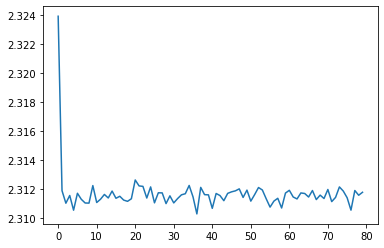

In [26]:
import matplotlib.pyplot as plt

plt.plot(result3.history['loss'])

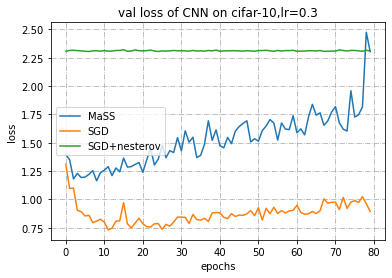

In [32]:
plt.plot(result1.history['val_loss'],label='MaSS')
plt.plot(result2.history['val_loss'],label='SGD')
plt.plot(result3.history['val_loss'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("val loss of CNN on cifar-10,lr=0.3")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

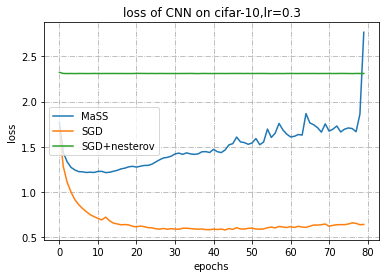

In [39]:
plt.plot(result1.history['loss'],label='MaSS')
plt.plot(result2.history['loss'],label='SGD')
plt.plot(result3.history['loss'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss of CNN on cifar-10,lr=0.3")
plt.grid(linestyle='-.')
plt.legend()
plt.show() 

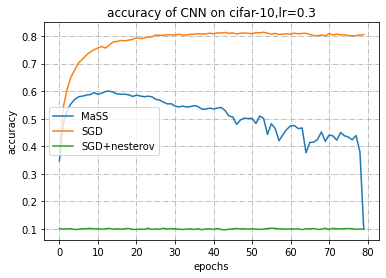

In [35]:
plt.plot(result1.history['acc'],label='MaSS')
plt.plot(result2.history['acc'],label='SGD')
plt.plot(result3.history['acc'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("accuracy of CNN on cifar-10,lr=0.3")
plt.grid(linestyle='-.')
plt.legend()
plt.show()

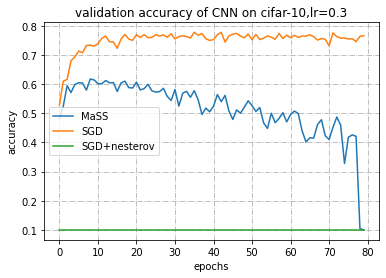

In [43]:
plt.plot(result1.history['val_acc'],label='MaSS')
plt.plot(result2.history['val_acc'],label='SGD')
plt.plot(result3.history['val_acc'],label='SGD+nesterov')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("validation accuracy of CNN on cifar-10,lr=0.3")
plt.grid(linestyle='-.')
plt.legend()
plt.show()

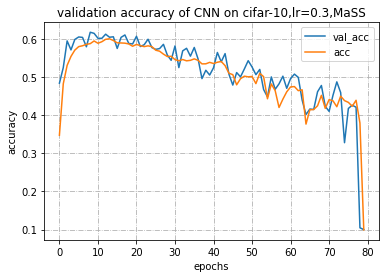

In [31]:
plt.plot(result1.history['val_acc'],label='val_acc')
plt.plot(result1.history['acc'],label='acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("validation accuracy of CNN on cifar-10,lr=0.3,MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show()

In [40]:
channel = 3
height = 32
width = 32
class_num = 10
norm_size = 32

model = Lenet.neural(channel=channel, height=height,width=width, classes=class_num)#网络
# model = resnet_v1(input_shape=input_shape, depth=depth)
mass = MaSS(learning_rate = 0.3, alpha = 0.05, kappa_t = 6)
model.compile(loss='categorical_crossentropy',
              optimizer=mass,
              metrics=['accuracy'])
model.summary()

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model_mass.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)
callbacks = [checkpoint]

# Training
if not data_augmentation:
    result_test = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,           	# set input mean to 0 over the dataset
        samplewise_center=False,            	# set each sample mean to 0        
        featurewise_std_normalization=False,    # divide inputs by std of dataset        
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening        
        rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)        
        width_shift_range=0.1,                  # randomly shift images horizontally        
        height_shift_range=0.1,                 # randomly shift images vertically        
        horizontal_flip=True,                   # randomly flip images        
        vertical_flip=False)                    # randomly flip images

    res_test = datagen.fit(x_train)
    # Fit the model on the batches generated by datagen.flow().
    result_test = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                                 callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        102464    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         204928    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
__________

782/782 [==============================] - 12s 16ms/step - loss: 1.3708 - acc: 0.5635 - val_loss: 1.4954 - val_acc: 0.5257

Epoch 00030: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.030.h5
Epoch 31/80
782/782 [==============================] - 12s 15ms/step - loss: 1.3686 - acc: 0.5643 - val_loss: 1.4300 - val_acc: 0.5572

Epoch 00031: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.031.h5
Epoch 32/80
782/782 [==============================] - 12s 15ms/step - loss: 1.3640 - acc: 0.5657 - val_loss: 1.3477 - val_acc: 0.5697

Epoch 00032: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.032.h5
Epoch 33/80
782/782 [==============================] - 12s 16ms/step - loss: 1.4045 - acc: 0.5573 - val_loss: 1.4244 - val_acc: 0.5703

Epoch 00033: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.033.h5
Epoch 34/80
782/782 [==============================] - 12s 15ms/step - loss: 1.3998 - ac


Epoch 00065: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.065.h5
Epoch 66/80
782/782 [==============================] - 12s 16ms/step - loss: 1.7053 - acc: 0.4346 - val_loss: 1.7813 - val_acc: 0.4114

Epoch 00066: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.066.h5
Epoch 67/80
782/782 [==============================] - 12s 15ms/step - loss: 1.6597 - acc: 0.4495 - val_loss: 1.8173 - val_acc: 0.4481

Epoch 00067: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.067.h5
Epoch 68/80
782/782 [==============================] - 12s 16ms/step - loss: 1.6596 - acc: 0.4513 - val_loss: 1.5825 - val_acc: 0.5057

Epoch 00068: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v1_model_mass.068.h5
Epoch 69/80
782/782 [==============================] - 11s 15ms/step - loss: 1.6416 - acc: 0.4547 - val_loss: 1.8774 - val_acc: 0.3590

Epoch 00069: saving model to C:\Users\dy1y19\saved_models\cifar10_ResNet32v

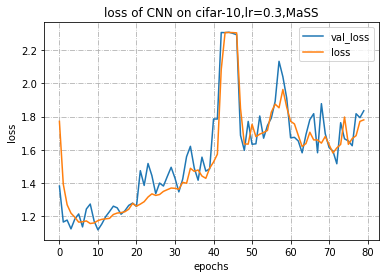

In [42]:
plt.plot(result_test.history['val_loss'],label='val_loss')
plt.plot(result_test.history['loss'],label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss of CNN on cifar-10,lr=0.3,MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show()

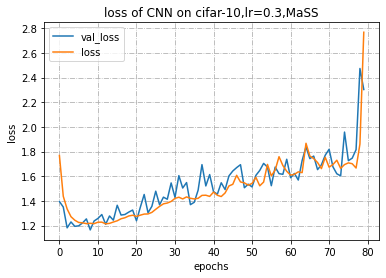

In [44]:
plt.plot(result1.history['val_loss'],label='val_loss')
plt.plot(result1.history['loss'],label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss of CNN on cifar-10,lr=0.3,MaSS")
plt.grid(linestyle='-.')
plt.legend()
plt.show()